# Sleep Quality Predictors.Model Classification

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split,KFold, cross_val_score

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import precision_score,recall_score,f1_score

from klib import data_cleaning

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


In [4]:
df=pd.read_csv('model yaratish/uyqu sifati classification model/sleep_cycle_productivity.csv')
df.info()
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'model yaratish/uyqu sifati classification model/sleep_cycle_productivity.csv'

# Data Preprocessing

In [359]:
df.isnull().sum() 
print(klib.missingval_plot(df))

No missing values found in the dataset.
None


In [360]:
df.drop(columns=['Date'], inplace=True)
df.drop(columns=['Person_ID'], inplace=True)
df.drop(columns=['Sleep Start Time'], inplace=True)
df.drop(columns=['Sleep End Time'], inplace=True)

In [340]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            5000 non-null   int64  
 1   Gender                         5000 non-null   object 
 2   Total Sleep Hours              5000 non-null   float64
 3   Sleep Quality                  5000 non-null   int64  
 4   Exercise (mins/day)            5000 non-null   int64  
 5   Caffeine Intake (mg)           5000 non-null   int64  
 6   Screen Time Before Bed (mins)  5000 non-null   int64  
 7   Work Hours (hrs/day)           5000 non-null   float64
 8   Productivity Score             5000 non-null   int64  
 9   Mood Score                     5000 non-null   int64  
 10  Stress Level                   5000 non-null   int64  
dtypes: float64(2), int64(8), object(1)
memory usage: 429.8+ KB


,Age,Gender,Total Sleep Hours,Sleep Quality,Exercise (mins/day),Caffeine Intake (mg),Screen Time Before Bed (mins),Work Hours (hrs/day),Productivity Score,Mood Score,Stress Level
0,32,Other,5.28,3,86,87,116,8.808920,8,3,6
1,41,Female,5.41,5,32,21,88,6.329833,10,3,7
2,20,Male,5.35,7,17,88,59,8.506306,10,9,10
3,37,Other,7.55,8,46,34,80,6.070240,8,4,2
4,46,Other,6.75,10,61,269,94,11.374994,8,7,9


In [361]:
def categorize_sleep_quality(score):
    if score <= 2:
        return 'Poor'
    elif score <= 5:
        return 'Okay'
    elif score <= 7:
        return 'Good'
    else:
        return 'Excellent'
df['Sleep Quality'] = df['Sleep Quality'].apply(categorize_sleep_quality)


# Encoding

In [362]:
dummies = pd.get_dummies(df['Gender'], prefix='Gender', dtype='int')
df = pd.concat([df, dummies], axis=1)
df.drop(columns=['Gender'], inplace=True)

In [1]:
encoder = OrdinalEncoder(categories=[['Poor','Okay','Good','Excellent']])
df[['Sleep Quality']] = encoder.fit_transform(df[['Sleep Quality']])
df['Sleep Quality'] = df['Sleep Quality'].astype(int)

NameError: name 'OrdinalEncoder' is not defined

In [363]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            5000 non-null   int64  
 1   Total Sleep Hours              5000 non-null   float64
 2   Sleep Quality                  5000 non-null   object 
 3   Exercise (mins/day)            5000 non-null   int64  
 4   Caffeine Intake (mg)           5000 non-null   int64  
 5   Screen Time Before Bed (mins)  5000 non-null   int64  
 6   Work Hours (hrs/day)           5000 non-null   float64
 7   Productivity Score             5000 non-null   int64  
 8   Mood Score                     5000 non-null   int64  
 9   Stress Level                   5000 non-null   int64  
 10  Gender_Female                  5000 non-null   int64  
 11  Gender_Male                    5000 non-null   int64  
 12  Gender_Other                   5000 non-null   i

,Age,Total Sleep Hours,Sleep Quality,Exercise (mins/day),Caffeine Intake (mg),Screen Time Before Bed (mins),Work Hours (hrs/day),Productivity Score,Mood Score,Stress Level,Gender_Female,Gender_Male,Gender_Other
0,32,5.28,Okay,86,87,116,8.808920,8,3,6,0,0,1
1,41,5.41,Okay,32,21,88,6.329833,10,3,7,1,0,0
2,20,5.35,Good,17,88,59,8.506306,10,9,10,0,1,0
3,37,7.55,Excellent,46,34,80,6.070240,8,4,2,0,0,1
4,46,6.75,Excellent,61,269,94,11.374994,8,7,9,0,0,1


# Scaling

In [364]:
standard_scale_cols = [
    'Age', 'Total Sleep Hours', 'Work Hours (hrs/day)',
    'Productivity Score', 'Mood Score', 'Stress Level'
]

minmax_scale_cols = ['Sleep Start Time', 'Sleep End Time']
robust_scale_cols = ['Exercise (mins/day)', 'Caffeine Intake (mg)', 'Screen Time Before Bed (mins)']

In [365]:
df[standard_scale_cols] = StandardScaler().fit_transform(df[standard_scale_cols])

df[robust_scale_cols] = RobustScaler().fit_transform(df[robust_scale_cols])

# Model Training

In [366]:
x = df.copy()
y = df['Sleep Quality']
x.drop(columns=['Sleep Quality'], inplace=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [367]:
lg = LogisticRegression(max_iter=1000)
lg.fit(x_train, y_train)
y_pred = lg.predict(x_test)
print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_pred))
print("Logistic Regression Classification Report: \n", classification_report(y_test, y_pred))

Logistic Regression Accuracy:  0.2755
Logistic Regression Classification Report: 
               precision    recall  f1-score   support

   Excellent       0.31      0.25      0.27       618
        Good       0.17      0.05      0.08       403
        Okay       0.29      0.62      0.39       585
        Poor       0.12      0.04      0.06       394

    accuracy                           0.28      2000
   macro avg       0.22      0.24      0.20      2000
weighted avg       0.24      0.28      0.23      2000



In [368]:
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)

DecisionTreeClassifier()

In [369]:
y_pred = dt_model.predict(x_val)
cr_report = classification_report(y_val, y_pred)
print(classification_report(y_val, y_pred))
ac_score = accuracy_score(y_val, y_pred)
print('accuracy score: ', accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

   Excellent       0.27      0.24      0.25       603
        Good       0.20      0.22      0.21       387
        Okay       0.29      0.26      0.28       620
        Poor       0.19      0.22      0.20       390

    accuracy                           0.24      2000
   macro avg       0.23      0.24      0.23      2000
weighted avg       0.24      0.24      0.24      2000

accuracy score:  0.2395


# Random Forest

In [370]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [371]:

y_pred = rf.predict(x_val)
cr_report1 = classification_report(y_val, y_pred)
print(cr_report1)
ac_score1 = accuracy_score(y_val, y_pred)
print('accuracy score: ', accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

   Excellent       0.31      0.31      0.31       603
        Good       0.19      0.11      0.14       387
        Okay       0.31      0.49      0.38       620
        Poor       0.18      0.09      0.12       390

    accuracy                           0.28      2000
   macro avg       0.25      0.25      0.24      2000
weighted avg       0.26      0.28      0.26      2000

accuracy score:  0.2845


# Gradient Boosting Classifier

In [379]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
gb_model.fit(x_train, y_train)
y_pred = gb_model.predict(x_val)
cr_report2 = classification_report(y_val, y_pred)
print(cr_report2)
ac_score2 = accuracy_score(y_val, y_pred)
print('accuracy score: ', accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

   Excellent       0.31      0.28      0.29       603
        Good       0.20      0.14      0.17       387
        Okay       0.32      0.46      0.38       620
        Poor       0.20      0.15      0.17       390

    accuracy                           0.28      2000
   macro avg       0.26      0.26      0.25      2000
weighted avg       0.27      0.28      0.27      2000

accuracy score:  0.285


# Model Comparison

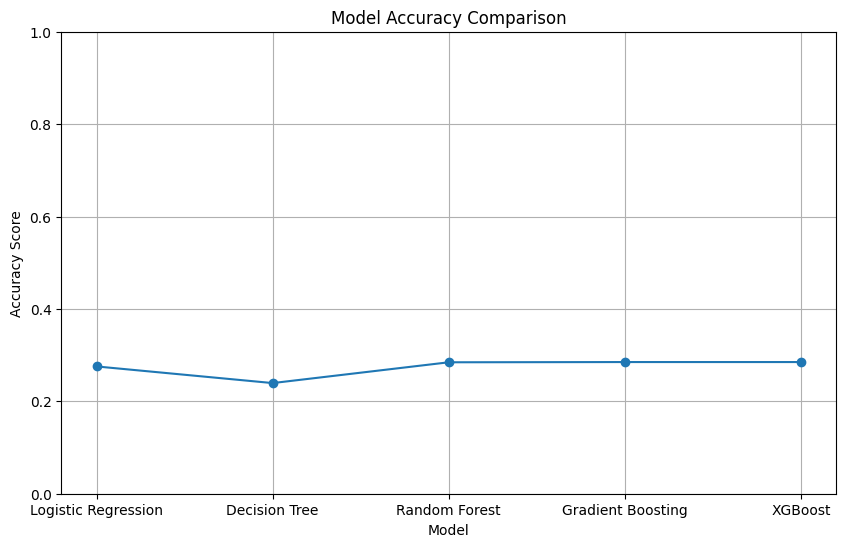

In [381]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'], 
         [accuracy_score(y_test, lg.predict(x_test)), ac_score, ac_score1, ac_score2, ac_score2], marker='o')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)
plt.grid()
plt.show()